In [1]:
!nvidia-smi
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from csbdeep.utils import plot_history,plot_some
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Wed Jul  7 15:42:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:17:00.0  On |                  Off |
| 33%   34C    P8    25W / 260W |  22876MiB / 24211MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:73:00.0 Off |                  Off |
| 33%   

(13, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210325_124A_N1TOM_day2_region1-1.tif
(17, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210327_124A_N1TOM_day4_region1-1.tif
(13, 1024, 1946) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210328_124A_N1TOM_day5_region1-1.tif
(12, 1024, 1946) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210329_124A_N1TOM_day6_region1_zoom07_Stitch-1.tif
(20, 973, 1434) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210330_124A_N1TOM_day7_region1_Stitch-1.tif
(9, 1281, 1236) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210402_124A_N1TOM_day10_region1_Stitch-1.tif
(29, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210601_131D_N1TOM_day1_region1-1.tif


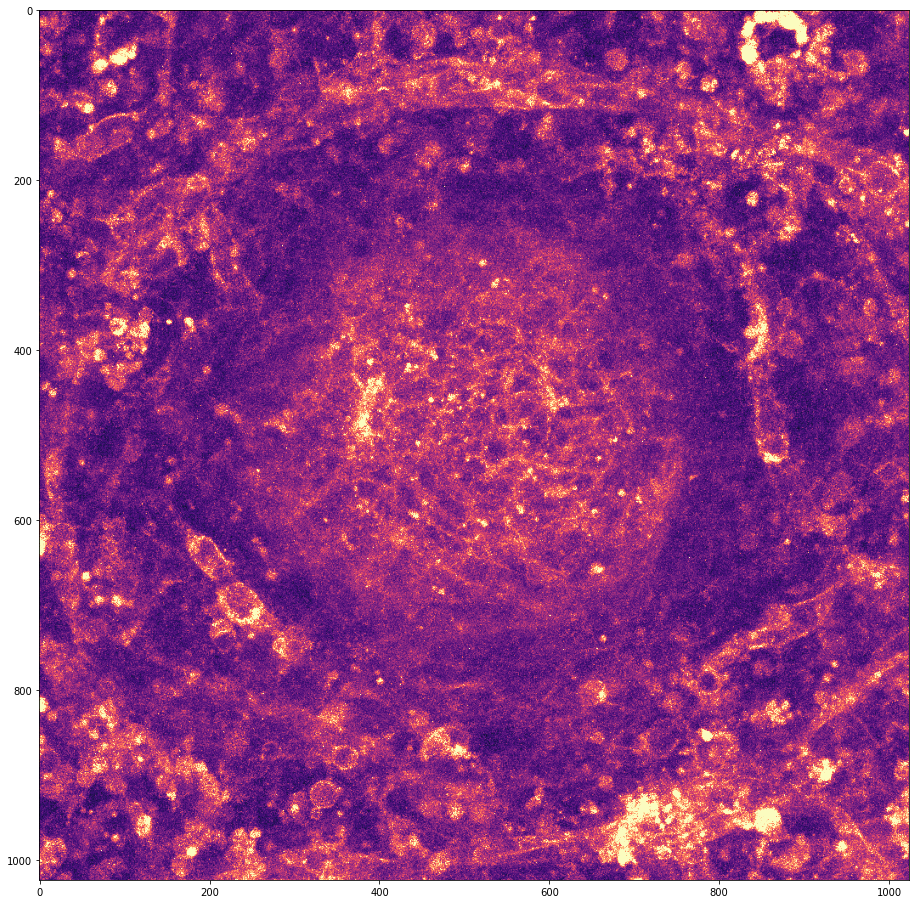

In [2]:
BaseDir =  '/home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/'

Model_Dir = '/home/sancere/Kepler/CurieDeepLearningModels/ClaudiaTomatoDenoising/'
Model_Name = 'N2VTomato'

datagen = N2V_DataGenerator()

imgs = datagen.load_imgs_from_directory(directory = BaseDir , dims='ZYX')
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()





Generated patches: (32, 8, 512, 512, 1)


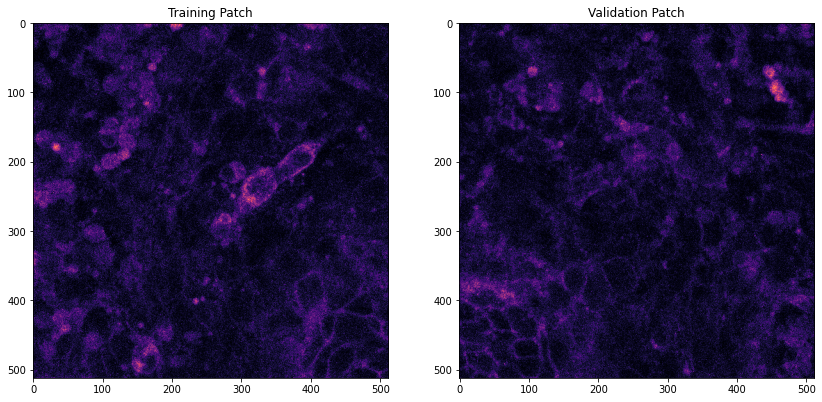

In [3]:
patch_shape = (8, 512, 512)
Epochs = 20
NetworkDepth = 3
batch_size = 1
patches = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape)
X = patches[:30]
X_val = patches[30:]

# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,1,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,1,...,0],cmap='magma')
plt.title('Validation Patch');

In [4]:
config = N2VConfig(X, unet_kern_size=3, unet_n_depth = NetworkDepth,
                   train_steps_per_epoch=400,train_epochs= Epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=batch_size, n2v_perc_pix=0.198,n2v_patch_shape= patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=4, train_checkpoint ='weights_now.h5' )

# Let's look at the parameters stored in the config-object.

model = N2V(config=config, name=Model_Name, basedir=Model_Dir)
vars(config)

/home/sancere/anaconda3/envs/tensorflowGPU/lib/python3.7/site-packages/n2v/models/n2v_standard.py:418: UserWarning: output path for model already exists, files may be overwritten: /home/sancere/Kepler/CurieDeepLearningModels/ClaudiaTomatoDenoising/N2VTomato
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
2021-07-07 15:42:13.692185: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-07 15:42:13.731144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:73:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-07-07 15:42:13.731467: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-07-07 15:42:13.733719: I tensorflow/stream_executor/platform/default

{'means': ['10.647479'],
 'stds': ['8.902211'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 1,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_now.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (8, 512, 512),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 4,
 'single_net_per_channel': True,
 'structN2Vmask': None,
 'probabilistic': False}

In [5]:

history = model.train(X, X_val)

Using TensorFlow backend.
Preparing validation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.22it/s]

4152 blind-spots will be generated per training patch of size (8, 512, 512).


Epoch 1/20


2021-07-07 15:42:19.212669: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-07-07 15:42:21.447490: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


400/400 [==============================] - 205s 511ms/step - loss: 0.5493 - n2v_mse: 0.5493 - n2v_abs: 0.5552 - val_loss: 0.4256 - val_n2v_mse: 0.4256 - val_n2v_abs: 0.4899 - lr: 4.0000e-04
Epoch 2/20
400/400 [==============================] - 203s 508ms/step - loss: 0.5081 - n2v_mse: 0.5081 - n2v_abs: 0.5379 - val_loss: 0.4243 - val_n2v_mse: 0.4243 - val_n2v_abs: 0.4926 - lr: 4.0000e-04
Epoch 3/20
400/400 [==============================] - 203s 508ms/step - loss: 0.5027 - n2v_mse: 0.5027 - n2v_abs: 0.5371 - val_loss: 0.3851 - val_n2v_mse: 0.3851 - val_n2v_abs: 0.4762 - lr: 4.0000e-04
Epoch 4/20
400/400 [==============================] - 203s 508ms/step - loss: 0.5047 - n2v_mse: 0.5047 - n2v_abs: 0.5366 - val_loss: 0.4171 - val_n2v_mse: 0.4171 - val_n2v_abs: 0.4922 - lr: 4.0000e-04
Epoch 5/20
400/400 [==============================] - 203s 509ms/step - loss: 0.5161 - n2v_mse: 0.5161 - n2v_abs: 0.5399 - val_loss: 0.3755 - val_n2v_mse: 0.3755 - val_n2v_abs: 0.4758 - lr: 4.0000e-04
Epoch 

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


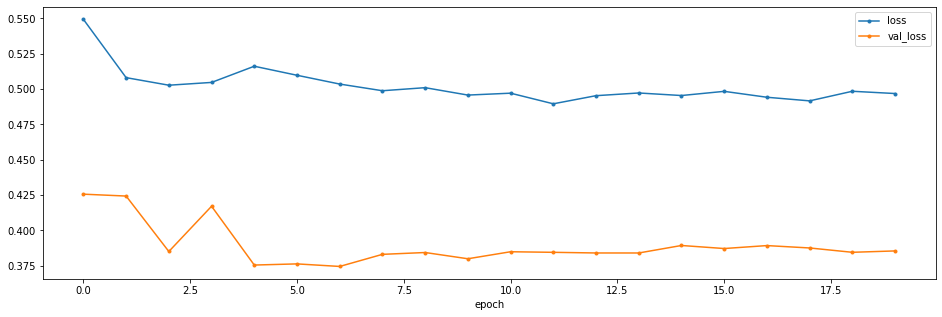

In [6]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

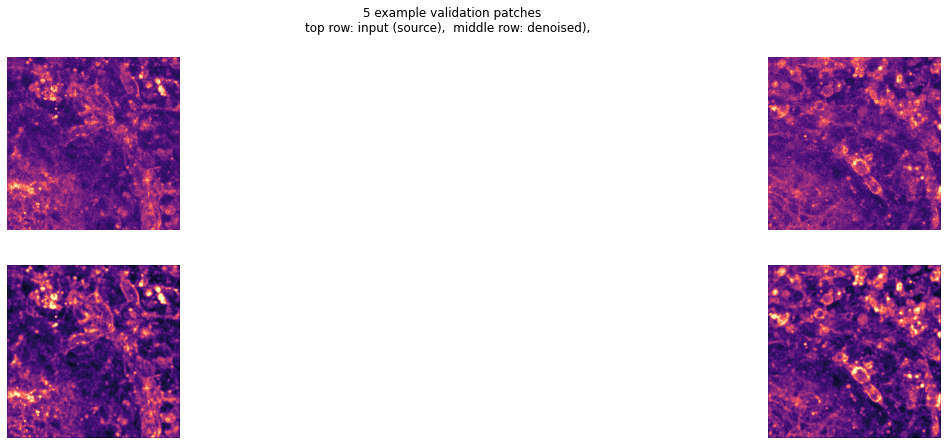

In [7]:
plt.figure(figsize=(25,7))
_P = model.keras_model.predict(X_val[:5])

plot_some(X_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: denoised),  '
             );